In [29]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from mlxtend.evaluate import bias_variance_decomp
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import classification_report
import os, csv
from data_clean import get_dataframe_from_file

In [30]:
df = get_dataframe_from_file("cleaned_data_combined.csv")
# pd.read_csv("../cleaned_output.csv")
df.dropna(inplace=True)

In [ ]:

df = df.drop(columns=['id'])

X = df.drop(columns=['Label']).to_numpy()

y = df['Label'].to_numpy()
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [33]:
# 60% for training and 20% validation, 20% for testing TODO: do we want to adjust this
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)

In [34]:
# Output data set splits
mapping = {
    'X_train': X_train,
    'y_train': y_train,
    'X_valid': X_valid,
    'y_valid': y_valid,
    'X_test': X_test,
    'y_test': y_test
}
# for name, data in mapping.items():
#     pd.DataFrame(data).to_csv(f'dataset/{name}.csv', index=False)

In [35]:
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': loguniform(1e-4, 1e-1),
    'learning_rate_init': loguniform(1e-4, 1e-2),
    'learning_rate': ['constant', 'adaptive']
}

# Train MLP Classifier
mlp = MLPClassifier(random_state=1, n_iter_no_change=100, early_stopping=True)

mlp.fit(X_train, y_train)

# This is without RandomizedSearch (just going through different combinations of prameters) - not a good idea
# best_model = parameter_tuning_workflow(X_train, y_train, X_valid, y_valid)

#This is what i use now
# optimizer = RandomizedSearchModelOptimizer(X_train, y_train, X_valid, y_valid, X_test, y_test)
# optimizer.create_results_file()

# base_mlp, base_mlp_params = optimizer.optimize_mlp(normalized=False)

# #takess best mlp and then bags it
# bagging_mlp, bagging_params = optimizer.optimize_bagging(base_mlp, normalized=False)

# normalized_mlp, normalized_mlp_params = optimizer.optimize_mlp(normalized=True)

# normalized_bagging_mlp, normalized_bagging_params = optimizer.optimize_bagging(normalized_mlp, normalized=True)

# Train bagged MLP Classifier
bagging = BaggingClassifier(mlp, n_estimators=10, max_samples=0.8, random_state=1, verbose=0)
bagging.fit(X_train, y_train)


/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


BaggingClassifier(estimator=MLPClassifier(early_stopping=True,
                                          n_iter_no_change=100,
                                          random_state=1),
                  max_samples=0.8, random_state=1)

In [ ]:
# Normalize the data

scaler = StandardScaler()
normalizer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), [0, 1 ,2])
    ],
    remainder='passthrough'  # Leave other columns unchanged (not sure if this is the issue.. im too lacking )
)

X_train_norm = normalizer.fit_transform(X_train)
X_valid_norm = normalizer.transform(X_valid)
X_test_norm = normalizer.transform(X_test)

# Train MLP Classifier with normalized data
nmlp = MLPClassifier(random_state=1, n_iter_no_change=100, early_stopping=True)
nmlp.fit(X_train_norm, y_train)

# Train bagged MLP Classifier with normalized data
normBagging = BaggingClassifier(nmlp, n_estimators=10, max_samples=0.8, random_state=1)
normBagging.fit(X_train_norm, y_train)

/Users/leoliu/Documents/code/ML_Challenge/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


array([[-0.20392194,  1.80530034, -0.72279406, ...,  1.        ,
         0.        ,  0.        ],
       [-0.20392194, -0.55392445,  1.38351994, ...,  0.        ,
         0.        ,  0.        ],
       [-0.20392194, -0.55392445, -0.72279406, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.20392194, -0.55392445, -0.72279406, ...,  0.        ,
         0.        ,  0.        ],
       [-0.20392194, -0.55392445, -0.72279406, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.90383718, -0.55392445, -0.72279406, ...,  0.        ,
         1.        ,  0.        ]], shape=(1052, 182))

In [37]:
def print_bias_variance_decomp(X_train, y_train, X_test, y_test):    
    expected_loss, bias, var = bias_variance_decomp(mlp,
                                                                X_train, y_train, 
                                                                X_test, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=42)
    expected_loss_bagged, bias_bagged, var_bagged = bias_variance_decomp(bagging,
                                                                X_train, y_train, 
                                                                X_test, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=42)
    expected_loss_norm, bias_norm, var_norm = bias_variance_decomp(nmlp,
                                                                X_train_norm, y_train, 
                                                                X_test_norm, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=42)
    expected_loss_bagged_norm, bias_bagged_norm, var_bagged_norm = bias_variance_decomp(normBagging,
                                                                X_train_norm, y_train, 
                                                                X_test_norm, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=42)

    print("Bias-Variance Decomposition Results")
    print("===================================")
    print(f"{'Model':<25} {'Expected Loss':<15} {'Bias':<15} {'Variance':<15}")
    print("-" * 70)
    print(f"{'MLP':<25} {expected_loss:.4f}{' '*10} {bias:.4f}{' '*10} {var:.4f}")
    print(f"{'Bagging MLP':<25} {expected_loss_bagged:.4f}{' '*10} {bias_bagged:.4f}{' '*10} {var_bagged:.4f}")
    print(f"{'Normalized MLP':<25} {expected_loss_norm:.4f}{' '*10} {bias_norm:.4f}{' '*10} {var_norm:.4f}")
    print(f"{'Normalized Bagging MLP':<25} {expected_loss_bagged_norm:.4f}{' '*10} {bias_bagged_norm:.4f}{' '*10} {var_bagged_norm:.4f}")

# print_bias_variance_decomp(X_train, y_train, X_test, y_test)

In [38]:
def export_model(model: MLPClassifier, filename: str, is_bagged: bool = False) -> None:
    """
    Save the bagged model. Note a bagged model is a collection of models, so we need to save each 
    one. This will also result different code for inference
    """
    if is_bagged:
        params = {}
        for i, estimator in enumerate(model.estimators_):
            for j in range(len(estimator.coefs_)):
                params[f'estimator_{i}_weights_{j}'] = estimator.coefs_[j]
                params[f'estimator_{i}_intercepts_{j}'] = estimator.intercepts_[j]
        params['num_estimators'] = len(model.estimators_)
        params['num_layers'] = len(model.estimators_[0].coefs_)
        params['classes'] = model.classes_
        np.savez(filename, **params)
    else:
        params = {f'weights_{i}': coef for i, coef in enumerate(model.coefs_)}
        params.update({f'biases_{i}': intercept for i, intercept in enumerate(model.intercepts_)})
        params['classes'] = model.classes_
        np.savez(filename, **params)

In [39]:
# Export the models
export_model(mlp, 'mlp_model.npz')
export_model(bagging, 'bagged_model.npz', is_bagged=True)


In [40]:
def score_and_export_results(model: MLPClassifier, X_train: pd.DataFrame, y_train: pd.Series, 
                             X_valid: pd.DataFrame, y_valid: pd.Series,
                             X_test: pd.DataFrame, y_test: pd.Series,
                             model_name: str, 
                             file_name: str) -> None:
    """
    Score the model and save the results of the model to file_name.
    """
    train_score = model.score(X_train, y_train)
    valid_score = model.score(X_valid, y_valid)
    test_score = model.score(X_test, y_test)
    print(f"Model: {model_name}")
    print(f"Training Score: {train_score:.4f}")
    print(f"Validation Score: {valid_score:.4f}")
    print(f"Test Score: {test_score:.4f}\n")
    
    params = {
        "Model": model_name,
        "Training Score": train_score,
        "Validation Score": valid_score,
        "hidden_layer_sizes": "",
        "activation": "",
        "solver": "",
        "alpha": "",
        "learning_rate_init": "",
        "learning_rate": "",
        "n_estimators": "",
        "max_samples": ""
    }
    
    fieldnames = [
        "Model", "Training Score", "Validation Score", "hidden_layer_sizes", 
        "activation", "solver", "alpha", "learning_rate_init", "learning_rate", 
        "n_estimators", "max_samples"
    ]
    
        
        
    if isinstance(model, BaggingClassifier):
        base_model = model.estimator_  # Access base estimator
        params["n_estimators"] = model.n_estimators
        params["max_samples"] = model.max_samples

    if isinstance(model, MLPClassifier):
        params["hidden_layer_sizes"] = str(model.hidden_layer_sizes)
        params["activation"] = model.activation
        params["solver"] = model.solver
        params["alpha"] = model.alpha
        params["learning_rate_init"] = model.learning_rate_init
        if model.solver == 'sgd':
            params["learning_rate"] = model.learning_rate

    # Write to CSV
    file_exists = os.path.isfile(file_name)
    with open(file_name, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        writer.writerows([params])

In [41]:
models = {
    "Base": (mlp, X_valid, y_valid, X_train, y_train, X_test, y_test),
    "Bagging": (bagging, X_valid, y_valid, X_train, y_train, X_test, y_test),
    "Normalized": (nmlp, X_valid_norm, y_valid, X_train_norm, y_train, X_test_norm, y_test),
    "Normalized Bagging": (normBagging, X_valid_norm, y_valid, X_train_norm, y_train, X_test_norm, y_test)
}

for name, (model, X_valid, y_valid, X_train, y_train, X_test, y_test) in models.items():
    score_and_export_results(model, X_train, y_train, X_valid, y_valid, X_test, y_test, name, "model_results.csv")

# score_and_export_results(best_model, X_train, y_train, X_valid, y_valid, "Best MLP", "model_results.csv")

Model: Base
Training Score: 0.9591
Validation Score: 0.9240
Test Score: 0.8875

Model: Bagging
Training Score: 0.9278
Validation Score: 0.9049
Test Score: 0.8784

Model: Normalized
Training Score: 0.9639
Validation Score: 0.9163
Test Score: 0.8875

Model: Normalized Bagging
Training Score: 0.9268
Validation Score: 0.9087
Test Score: 0.8784



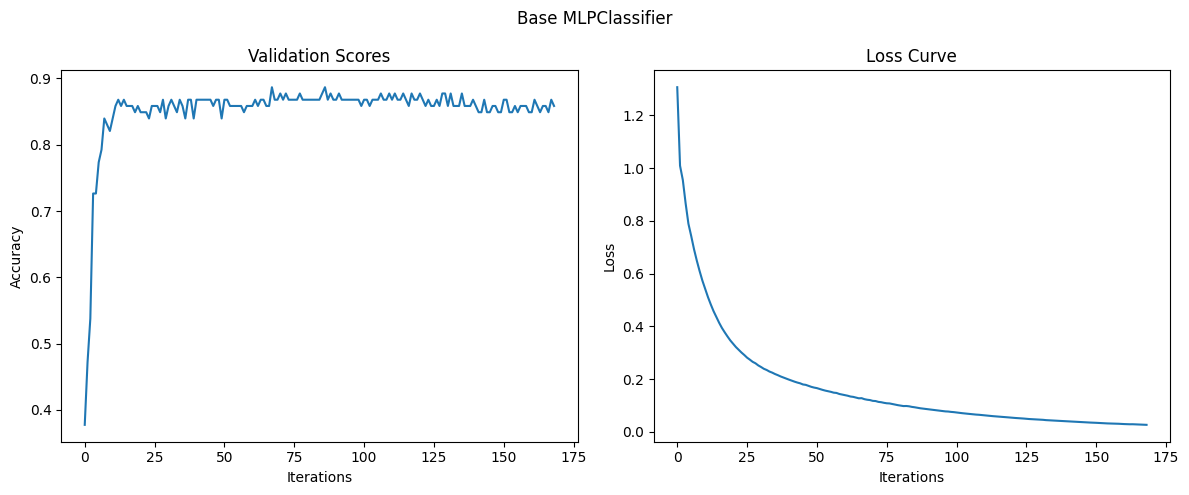

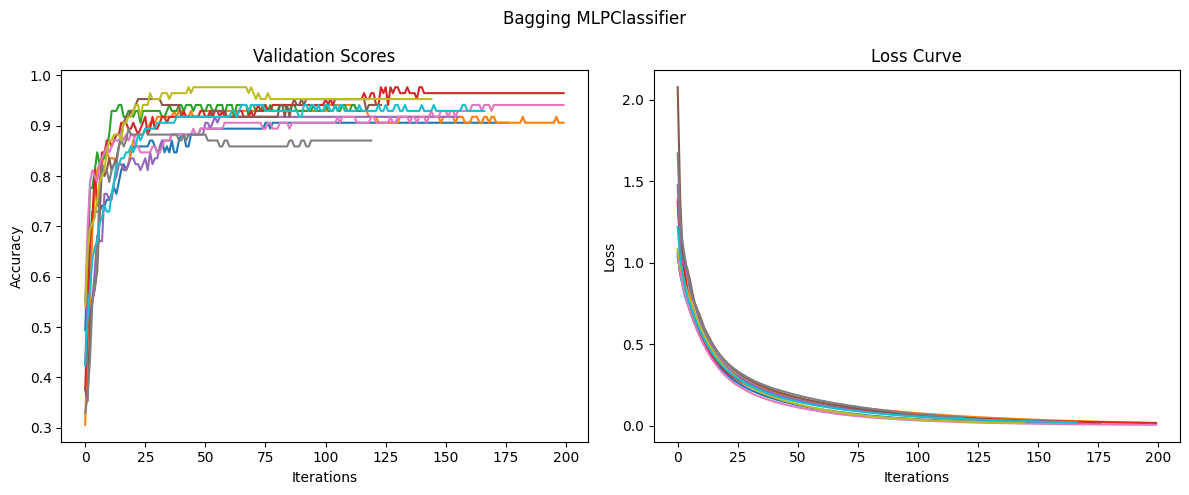

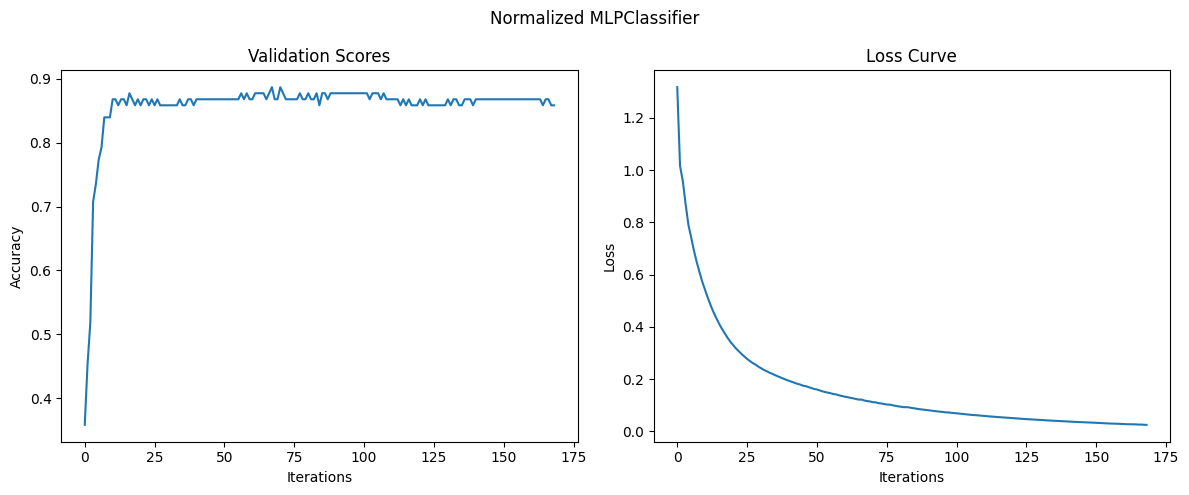

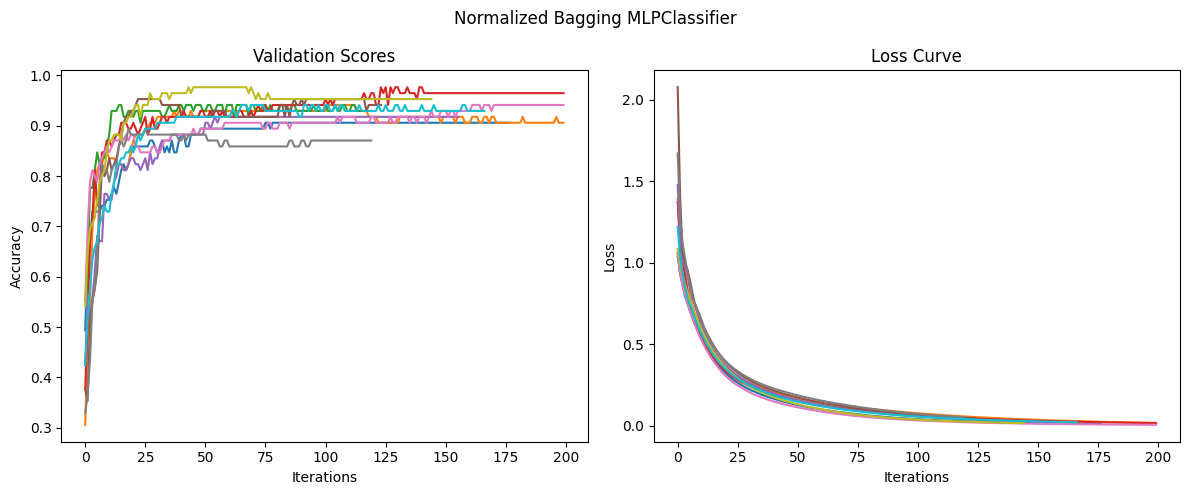

In [42]:
from nn.plot import plot_single_model, plot_bagging_training_progress

plot_single_model(mlp, "Base MLPClassifier")
plot_bagging_training_progress(bagging, "Bagging MLPClassifier")
plot_single_model(nmlp, "Normalized MLPClassifier")
plot_bagging_training_progress(bagging, "Normalized Bagging MLPClassifier")



